In [80]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import datetime as dt
import numpy as np

In [32]:
import plotly.express as px

In [58]:
date_block_mapping = {
    0: dt.datetime(2013, 1, 1), 1: dt.datetime(2013, 2, 1), 2: dt.datetime(2013, 3, 1), 3: dt.datetime(2013, 4, 1),
    4: dt.datetime(2013, 5, 1), 5: dt.datetime(2013, 6, 1), 6: dt.datetime(2013, 7, 1), 7: dt.datetime(2013, 8, 1),
    8: dt.datetime(2013, 9, 1), 9: dt.datetime(2013, 10, 1), 10: dt.datetime(2013, 11, 1), 11: dt.datetime(2013, 12, 1),
    12: dt.datetime(2014, 1, 1), 13: dt.datetime(2014, 2, 1), 14: dt.datetime(2014, 3, 1), 15: dt.datetime(2014, 4, 1),
    16: dt.datetime(2014, 5, 1), 17: dt.datetime(2014, 6, 1), 18: dt.datetime(2014, 7, 1), 19: dt.datetime(2014, 8, 1),
    20: dt.datetime(2014, 9, 1), 21: dt.datetime(2014, 10, 1), 22: dt.datetime(2014, 11, 1), 23: dt.datetime(2014, 12, 1),
    24: dt.datetime(2015, 1, 1), 25: dt.datetime(2015, 2, 1), 26: dt.datetime(2015, 3, 1), 27: dt.datetime(2015, 4, 1),
    28: dt.datetime(2015, 5, 1), 29: dt.datetime(2015, 6, 1), 30: dt.datetime(2015, 7, 1), 31: dt.datetime(2015, 8, 1),
    32: dt.datetime(2015, 9, 1), 33: dt.datetime(2015, 10, 1)
}

# Plan


## 1. Exploratory data analysis and visualization:

    - What timeframe was the dataset collected?
        2 years 10 months - Jan 2013 - Oct 2015

    - What is the average number of sales per month? What shops perform above and below this average (outliers)?
        Data is negatively skewed - more shops have sales within the lower end from 0 to ~3000
        Get mean, median, standard deviation and interquartile range
        Coefficient of variation - how much do shops vary in number of sales per month? Is this significant?
        How to remove outliers or split shops up by popularity/number of sales? z score or interquartile range?


    - Do certain shops have more typical purchasing behaviours? Is there a measurable pattern?
        time series analysis: trend, covariance, seasonality, variation
        Is there a difference in the patterns across or within the groups (popularity of shops)
        Is there a difference across years? Cycle?
        Is there a way to group shops by trend? eg are some shops visited more during christmas and others are visited more during the weekends


    - Same for items? Which items and shops are worth further exploration?

## 2. Model fitting and predictions

    Starting with simple model then complex - most likely not enough data for deep learning/AI

        - Regression: ARIMA, Exponential smoothing
            Variables:
                Month/Season/Event 
                Number of sales in the previous year?
                popularity of shop?
                Number of popular items in shop?
                Average in last 2/3 months


        - Bayesian 

        - Machine Learning
            Can K-means clustering be used to determine whether there is a pattern and what the variables are?
            SVM & XGBOOST

    
    


In [19]:
sales = pd.read_csv('competitive-data-science-predict-future-sales/sales_train.csv')
sales['date'] = pd.to_datetime(sales['date'], dayfirst=True)
sales['year'] = sales['date'].dt.year
sales['month'] = sales['date'].dt.month

sales.head()

,date,date_block_num,shop_id,item_id,item_price,item_cnt_day,year,month
0,2013-01-02,0,59,22154,999.00,1.0,2013,1
1,2013-01-03,0,25,2552,899.00,1.0,2013,1
2,2013-01-05,0,25,2552,899.00,-1.0,2013,1
3,2013-01-06,0,25,2554,1709.05,1.0,2013,1
4,2013-01-15,0,25,2555,1099.00,1.0,2013,1


In [59]:
monthly_sales = sales.groupby(['shop_id', 'date_block_num'])['item_cnt_day'].sum().reset_index()
monthly_sales['date'] = monthly_sales['date_block_num'].map(date_block_mapping)
monthly_sales.head()

,shop_id,date_block_num,item_cnt_day,date
0,0,0,5578.0,2013-01-01
1,0,1,6127.0,2013-02-01
2,1,0,2947.0,2013-01-01
3,1,1,3364.0,2013-02-01
4,2,0,1146.0,2013-01-01


In [97]:
monthly_sales

,shop_id,date_block_num,item_cnt_day,date,month_year,month,z_score
0,0,0,5578.0,2013-01-01,2013-01,2013-01,1.249475
1,0,1,6127.0,2013-02-01,2013-02,2013-02,1.628894
2,1,0,2947.0,2013-01-01,2013-01,2013-01,0.011875
3,1,1,3364.0,2013-02-01,2013-02,2013-02,0.282380
4,2,0,1146.0,2013-01-01,2013-01,2013-01,-0.835301
...,...,...,...,...,...,...,...
1581,59,29,913.0,2015-06-01,2015-06,2015-06,-0.475503
1582,59,30,992.0,2015-07-01,2015-07,2015-07,-0.430520
1583,59,31,1214.0,2015-08-01,2015-08,2015-08,-0.332193
1584,59,32,914.0,2015-09-01,2015-09,2015-09,-0.486059


    - What timeframe was the dataset collected?

Jan 2013 - Oct 2015

In [101]:
print(sales['date'].max(),sales['date'].min())

2015-10-31 00:00:00 2013-01-01 00:00:00


    
    - What is the average number of sales per month? What shops perform above and below this average (outliers)?
    
    - Data is negatively skewed - more shops have sales within the lower end from 0 to ~3000

    - Coefficient of variation - how much do shops vary in number of sales per month? Is this significant?
        
    - How to remove outliers or split shops up by popularity/number of sales? z score or interquartile range?
    - What is the mean, median and std per month?
    - Is there actually a measurable pattern in the data/time series?
    - What does this say about the data?

Average number of sales: 1500-4000 (Highest December 2013 3985 sales, lowest July 2015 1469 sales)

However, coefficient of variation (0.7-0.9) shows there is relatively high variability in sales between shops  

### First step should be to find boundaries for grouping shops based on average monthly sales or other patterns


In [113]:

grouped = monthly_sales.groupby(monthly_sales['date'].dt.to_period('M'))['item_cnt_day'].agg(['mean', 'median', 'std'])
grouped.columns = ['mean', 'median', 'std']

months = grouped.index.to_series().dt.month.astype(str) + '-' + grouped.index.to_series().dt.year.astype(str)
grouped.index = months
grouped.index = pd.to_datetime(grouped.index)

grouped.head()


/var/folders/96/ntd6ngxn5klgfg7ylpwj8n_h0000gn/T/ipykernel_1957/3108999779.py:6: UserWarning:

Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.



,mean,median,std
date,,,
2013-01-01,2921.755556,2127.0,2125.887602
2013-02-01,2784.565217,2210.5,2051.965764
2013-03-01,3198.739130,2536.0,2407.951600
2013-04-01,2330.217391,1863.0,1895.456016
2013-05-01,2377.111111,1931.0,1806.277038


In [112]:
print(grouped.loc[grouped['mean'].idxmax()],"\n",grouped.loc[grouped['mean'].idxmin()])

mean      3985.695652
median    3120.500000
std       3094.483772
Name: 2013-12-01 00:00:00, dtype: float64 
 mean      1469.465116
median    1114.000000
std       1109.043396
Name: 2015-07-01 00:00:00, dtype: float64


In [115]:
cv = grouped['std'] / grouped['mean']
print(cv.loc[cv.idxmax()],"\n",cv.loc[cv.idxmin()])

0.9473247943120834 
 0.6874869930251142


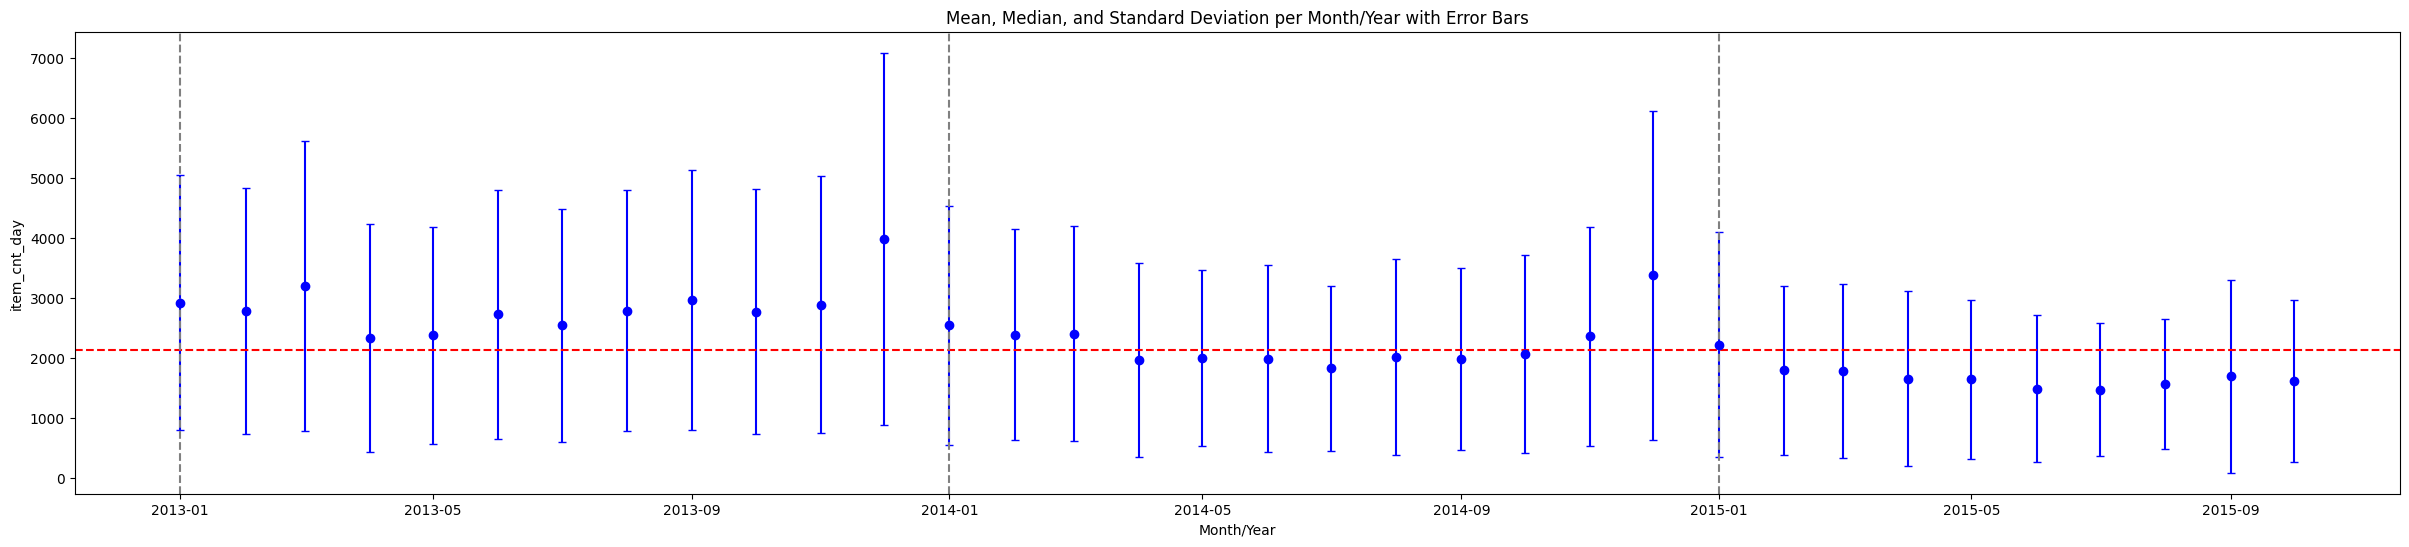

In [87]:

fig, ax = plt.subplots(figsize=(30,6))
ax.errorbar(grouped.index, grouped['mean'], yerr=grouped['std'], fmt='o', capsize=3, color='b')
ax.axhline(grouped['median'].iloc[0], color='r', linestyle='--', label='Median')
ax.set_xlabel('Month/Year')
ax.set_ylabel('item_cnt_day')
ax.set_title('Mean, Median, and Standard Deviation per Month/Year with Error Bars')

for year in grouped.index.to_series().dt.year.unique():
    ax.axvline(x=grouped.index[grouped.index.to_series().dt.year == year].min(), color='grey', linestyle='--')

plt.show()

In [91]:
z_scores = monthly_sales.groupby(monthly_sales['date'].dt.to_period('M'))['item_cnt_day'].apply(lambda x: (x - x.mean()) / x.std())

# Reset the index of the z_scores series to be the same as the index of the monthly_sales dataframe
z_scores = z_scores.reset_index(level=0, drop=True)

# Create a new column 'z_score' in the monthly_sales dataframe
monthly_sales['z_score'] = z_scores

# Define a threshold for outliers (e.g., 2 standard deviations)
threshold = 2.5

# Find shop_id's that are outliers for each month
outliers = monthly_sales[(monthly_sales['z_score'] > threshold) | (monthly_sales['z_score'] < -threshold)]

# Group outliers by month and shop_id
outliers_grouped = outliers.groupby([outliers['date'].dt.to_period('M'), 'shop_id'])['item_cnt_day'].count()

print(outliers_grouped)

date     shop_id
2013-01  31         1
         54         1
2013-02  25         1
         31         1
         54         1
                   ..
2015-09  25         1
         31         1
         55         1
2015-10  25         1
         31         1
Name: item_cnt_day, Length: 68, dtype: int64


In [230]:
outliers_grouped

date     shop_id
2013-01  31         1
         54         1
2013-02  25         1
         31         1
         54         1
                   ..
2015-09  25         1
         31         1
         55         1
2015-10  25         1
         31         1
Name: item_cnt_day, Length: 68, dtype: int64

In [95]:
outliers_dates = outliers_grouped.index.get_level_values(0).to_timestamp()
outliers_shops = outliers_grouped.index.get_level_values(1)

filtered_sales = monthly_sales[~(monthly_sales['date'].isin(outliers_dates) & monthly_sales['shop_id'].isin(outliers_shops))]

In [96]:
filtered_sales

,shop_id,date_block_num,item_cnt_day,date,month_year,month,z_score
0,0,0,5578.0,2013-01-01,2013-01,2013-01,1.249475
1,0,1,6127.0,2013-02-01,2013-02,2013-02,1.628894
2,1,0,2947.0,2013-01-01,2013-01,2013-01,0.011875
3,1,1,3364.0,2013-02-01,2013-02,2013-02,0.282380
4,2,0,1146.0,2013-01-01,2013-01,2013-01,-0.835301
...,...,...,...,...,...,...,...
1581,59,29,913.0,2015-06-01,2015-06,2015-06,-0.475503
1582,59,30,992.0,2015-07-01,2015-07,2015-07,-0.430520
1583,59,31,1214.0,2015-08-01,2015-08,2015-08,-0.332193
1584,59,32,914.0,2015-09-01,2015-09,2015-09,-0.486059


In [100]:
# Filter shops that have a full time series for 2013
full_year_2013 = monthly_sales[(monthly_sales['date_block_num'] >= 0) & (monthly_sales['date_block_num'] <= 11)]
shops_2013 = full_year_2013['shop_id'].unique()

# Filter shops that have a full time series for 2014
full_year_2014 = monthly_sales[(monthly_sales['date_block_num'] >= 12) & (monthly_sales['date_block_num'] <= 23)]
shops_2014 = shops_2013.intersection(full_year_2014['shop_id'].unique())

# Filter shops that have a full time series for 2015
full_year_2015 = monthly_sales[(monthly_sales['date_block_num'] >= 24) & (monthly_sales['date_block_num'] <= 33)]
shops_2015 = shops_2014.intersection(full_year_2015['shop_id'].unique())

# Filter the monthly_sales dataframe to remove shops that don't have a full time series for a year
filtered_sales = monthly_sales[monthly_sales['shop_id'].isin(shops_2015)]

AttributeError: 'numpy.ndarray' object has no attribute 'intersection'

In [125]:
# Calculate Q1, Q3, and IQR for each shop
q1 = monthly_sales.groupby('month_year')['item_cnt_day'].quantile(0.25)
q3 = monthly_sales.groupby('month_year')['item_cnt_day'].quantile(0.75)
iqr = q3 - q1

# Calculate boundaries for each shop
lower_boundary = q1 - 1.5 * iqr
upper_boundary = q3 + 1.5 * iqr

# Create a DataFrame for the boundaries
boundaries = pd.DataFrame({'Q1': q1, 'Q3': q3, 'IQR': iqr, 'Lower Boundary': lower_boundary, 'Upper Boundary': upper_boundary})
boundaries.head()


In [228]:

# Create an empty dataframe to store the shop_ids that meet the condition
upper_df = pd.DataFrame()

# Iterate over each month_year in upper_boundary
for month_year, upper_boundary_value in upper_boundary.items():

    month_year = pd.to_datetime(month_year, format="%Y-%m")
    # Filter monthly_sales for the current month_year
    current_month_sales = monthly_sales[monthly_sales['date'] == month_year]
    
    # Compare item_cnt_day to the upper boundary value
    shop_ids_to_add = current_month_sales[current_month_sales['item_cnt_day'] > upper_boundary_value][['shop_id','month_year','item_cnt_day']]
    
    # Add the shop_ids to the result dataframe
    upper_df = pd.concat([upper_df, shop_ids_to_add], ignore_index=True)

upper_df.head()


,shop_id,month_year,item_cnt_day
0,0,2013-01,5578.0
1,25,2013-01,8215.0
2,27,2013-01,5548.0
3,28,2013-01,7057.0
4,31,2013-01,10173.0


In [229]:
upper_df

,shop_id,month_year,item_cnt_day
0,0,2013-01,5578.0
1,25,2013-01,8215.0
2,27,2013-01,5548.0
3,28,2013-01,7057.0
4,31,2013-01,10173.0
...,...,...,...
211,55,2015-09,6867.0
212,12,2015-10,4181.0
213,25,2015-10,6247.0
214,31,2015-10,6112.0


In [168]:
upper_boundary

month_year
2013-01    4956.500
2013-02    4407.125
2013-03    4870.000
2013-04    3901.125
2013-05    3801.500
2013-06    4877.625
2013-07    5277.375
2013-08    4684.000
2013-09    4970.000
2013-10    4751.500
2013-11    4513.000
2013-12    6783.125
2014-01    4503.625
2014-02    3739.750
2014-03    3891.625
2014-04    3107.500
2014-05    3083.500
2014-06    3149.500
2014-07    2805.500
2014-08    3217.000
2014-09    3367.250
2014-10    3484.625
2014-11    4150.000
2014-12    6295.750
2015-01    3950.000
2015-02    3197.500
2015-03    3122.500
2015-04    2905.750
2015-05    2614.375
2015-06    2694.000
2015-07    2721.500
2015-08    2685.500
2015-09    2580.250
2015-10    3207.500
Freq: M, Name: item_cnt_day, dtype: float64

In [170]:
monthly_sales[monthly_sales['item_cnt_day'].gt(upper_boundary.reindex(monthly_sales.index))]

,shop_id,date_block_num,item_cnt_day,date,month_year,month,z_score


In [172]:
monthly_sales

,shop_id,date_block_num,item_cnt_day,date,month_year,month,z_score
0,0,0,5578.0,2013-01-01,2013-01,2013-01,1.249475
1,0,1,6127.0,2013-02-01,2013-02,2013-02,1.628894
2,1,0,2947.0,2013-01-01,2013-01,2013-01,0.011875
3,1,1,3364.0,2013-02-01,2013-02,2013-02,0.282380
4,2,0,1146.0,2013-01-01,2013-01,2013-01,-0.835301
...,...,...,...,...,...,...,...
1581,59,29,913.0,2015-06-01,2015-06,2015-06,-0.475503
1582,59,30,992.0,2015-07-01,2015-07,2015-07,-0.430520
1583,59,31,1214.0,2015-08-01,2015-08,2015-08,-0.332193
1584,59,32,914.0,2015-09-01,2015-09,2015-09,-0.486059


In [60]:
fig = px.line(monthly_sales, x='date_block_num', y='item_cnt_day', color='shop_id', title='Monthly Sales by Shop')
fig.update_layout(xaxis_title='Month', yaxis_title='Number of Items Sold')
fig.show()

    - Are certain shops more popular than others?

Shop 31 most popular

Top 10 = 31, 25, 54, 28, 27, 42, 6, 18, 50, 19

In [45]:
selected_shops = [31, 25, 54, 28, 27, 42, 6, 18, 50, 19]
filtered_monthly_sales = monthly_sales[monthly_sales['shop_id'].isin(selected_shops)]

# Create the line plot
fig = px.line(filtered_monthly_sales, x='date_block_num', y='item_cnt_day', color='shop_id', title='Monthly Sales by Shop - Top 10')
fig.update_layout(xaxis_title='Month', yaxis_title='Number of Items Sold')
fig.show()

    - Do certain shops have more typical purchasing behaviours?

In [51]:
shop_data = {}
for shop_id, shop_df in monthly_sales.groupby('shop_id'):
    shop_df['month'] = shop_df['date_block_num'] % 12 + 1
    shop_df['year'] = shop_df['date_block_num'] // 12 + 2013
    shop_data[shop_id] = shop_df

# Create a separate plot for each shop
for shop_id, shop_df in shop_data.items():
    if shop_id in [31, 25, 54, 28, 27, 42, 6, 18, 50, 19]:
        fig = px.line(shop_df, x='month', y='item_cnt_day', color='year', title=f'Shop {shop_id} Sales by Month')
        fig.update_layout(xaxis_title='Month', yaxis_title='Number of Items Sold')
        fig.show()